In [37]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import pandas as pd

from scipy.special import gamma
from scipy.stats import invweibull as frechet
def myGamma(zeta):
    return gamma(1-1/zeta)

DIR = r"/home/cz/Dropbox/Summer RA Model EP/Parameters/"


class Params(object):
    pass

def read(name):
    myfile = os.path.join(DIR, 'ep_{}.csv'.format(name))
    df=pd.read_csv(myfile, header=None)
    return df

def pv(name, mat):
    print("{}: {}".format(name.rjust(10), mat.shape))
    
def read_matrix(name, verbose=True):
    df = read(name)
    mat = df.values
    if verbose:
        pv(name, mat)
    return mat

def read_params():
    param = Params()
    with open(os.path.join(DIR, 'ep_params.csv')) as f:
        lines = f.readlines()
        values = lines[0].split(',')
        names = lines[2].replace('[','').replace(']','').strip().split(' ')

        if len(values) != len(names):
            print('not sure how to read this...')
            print(lines)

        print('Found {} parameters'.format(len(values)))    
        for k,v in zip(names, values):
            print('{} = {}'.format(k,v))
            setattr(param, k.split('.')[1], float(v))
    
    return param

In [38]:
param = read_params()

Found 13 parameters
param.beta = 0.28818
param.q = 0.67565
param.mu = 3.4112
param.zeta = 1.62
param.alpha = 0.05
param.sigma = 4
param.psi = 0.76551
param.delta = 0.91803
param.eta = 0.35
param.gamma = 0.35055
param.nu = 0.0187
param.kappa = 0.42
param.r = 2.8866



In [39]:
myGamma(param.zeta)

2.3211529336709016

In [40]:
skills, wages = read_matrix("skill1880"), read_matrix("wage1880")
Q_A, Q_NA = read_matrix("Q_A"), read_matrix("Q_NA")

Z = read_matrix("Z")
vA = read_matrix("vA")
Capital = read_matrix("Capital")
phi = read_matrix("phi")

tau = read_matrix("tau")
amenities = read_matrix("amenities")

 skill1880: (645, 2)
  wage1880: (645, 2)
       Q_A: (645, 5)
      Q_NA: (645, 5)
         Z: (5, 2)
        vA: (5, 1)
   Capital: (5, 1)
       phi: (4, 1)
       tau: (645, 645)
 amenities: (645, 5)


## Mess with the variables a bit

In [41]:
# expand the axes
skills = np.expand_dims(skills, 2).transpose((2,1,0))
pv("skills", skills)

wages = np.expand_dims(wages, 2).transpose((2,1,0))
pv("wages", wages)

Q = np.stack((Q_A, Q_NA), axis=1).transpose((2,1,0))
pv("Q", Q)

vA = vA.flatten()
vAt= np.array([vA[1], 1-vA[1]]).reshape(2,1)
pv("vAt", vAt)

Capital = Capital.flatten()
pv("Capital", Capital)

pv("tau", tau)

amenities = amenities.transpose((1,0))
pv("amenities", amenities)

    skills: (1, 2, 645)
     wages: (1, 2, 645)
         Q: (5, 2, 645)
       vAt: (2, 1)
   Capital: (5,)
       tau: (645, 645)
 amenities: (5, 645)


In [42]:
# define some constants for indexing
A, NA = 0,1
L, H = 0,1
R,S,T = 2,1,0

Psi = np.array([[1,1],
                [1,1.6]])

In [7]:
overall_lamda = np.sum(skills, axis=R) # this is \lambda overall
Lrt = np.sum(skills, axis=S)
lam_rt = (skills/Lrt)

print(overall_lamda.shape, Lrt.shape, lam_rt.shape)

# now we can do things like this:
print('the first index is L-skill', np.sum(Lrt * lam_rt, axis=R))

(1, 2) (1, 645) (1, 2, 645)
the first index is L-skill [[0.7046579  0.29534209]]


# Define methods

Old:
```
regionalRevenue = (1-param.alpha) * pi[A] * vA[1] * GDP
regionalEarnings = Lrt * myGamma(param.zeta) * (lam_rt[t,L] * Psi[L,A] + lam_rt[t,H] * Psi[H,A])

newWages = regionalRevenue / regionalEarnings

regionalRevenue_NA = (1-param.alpha) * pi[NA] * (1 - vA[1]) * GDP
regionalEarnings_NA = Lrt * myGamma(param.zeta) * (lam_rt[t,L] * Psi[L,NA] + lam_rt[t,H] * Psi[H,NA])

newWages_NA = regionalRevenue_NA / regionalEarnings_NA
```

New:
```
regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))

newWages = regionalRevenue/x
```

Is it faster? I don't know if it's easier to read...

In [106]:
t = 0

# useful for resets
def readWages(verbose=False):
    wages = read_matrix("wage1880", verbose)
    wages = np.expand_dims(wages, 2).transpose((2,1,0))
    return wages

def readSkills():
    skills = read_matrix("skill1880")
    skills = np.expand_dims(skills, 2).transpose((2,1,0))
    return skills

def computePi(wages):
    pi = Q[t]**(param.sigma-1) * wages**((1-param.alpha)*(1-param.sigma))
    
    normalize = np.sum(pi, axis=R)
    normalize = np.expand_dims(normalize, 2)
    pi = pi / (normalize) # I left out the exponent here.. going by the paper??plus it gives different figures
    return pi

def computeTheta(wages):
    Theta = np.matmul(Psi, wages**(param.zeta)) ** (1/param.zeta)
    Theta_l = Theta[0,L]
    Theta_h = Theta[0,H]
    return Theta_h, Theta_l, Theta

def computeGDP(lam_rt, Theta_h, Theta_l):
    constant= 1/(1-param.alpha) * myGamma(param.zeta)
    GDP = constant * np.sum(Lrt * (lam_rt * Theta_h + (1-lam_rt) * Theta_l))
    return GDP
    

Text(0,0.5,'pi')

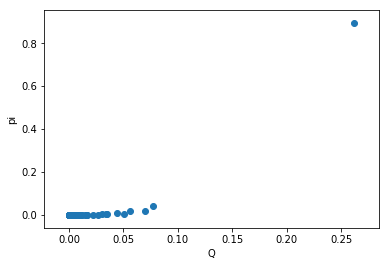

In [107]:
pi = computePi(wages)
plt.scatter(Q[t,NA], pi[t,NA])
plt.xlabel('Q'); plt.ylabel('pi')

In [108]:
wages = readWages()

def loopy(wages, log=True):
    lr = 0.1
    loss = 10

    for i in range(1000):

        pi = computePi(wages)
        Theta_h, Theta_l, Theta = computeTheta(wages)
        GDP = computeGDP(lam_rt, Theta_h, Theta_l)

        regionalRevenue = (1-param.alpha) * pi * vAt *  GDP
        x = Lrt * myGamma(param.zeta) * np.matmul(lam_rt.transpose((2,0,1)), Psi).transpose((1,2,0))

        newWages = regionalRevenue/x
        loss = np.sum(np.abs(newWages - wages))

        # update
        wages = lr * newWages + (1-lr) * wages
        
        if loss < 1e-6:
            if log:
            print('Iteration #{}: {}'.format(i, loss))
            break
            
        if i % 20 == 0 and log:
            print('Iteration #{}: {}'.format(i, loss))
            
    return wages


Iteration #0: 431.2296454836934
Iteration #20: 440.734095790072
Iteration #40: 2327.4192300165696
Iteration #60: 12056.118043028515
Iteration #80: 62423.496436197966
Iteration #100: 323209.5431149161
Iteration #120: 1673478.5654214881
Iteration #140: 8664751.86928538
Iteration #160: 44863392.037096255
Iteration #180: 232288699.714817
Iteration #200: 1202718688.113909
Iteration #220: 6227303543.023668
Iteration #240: 32243042201.138878
Iteration #260: 166944450868.96088
Iteration #280: 864386477618.2477
Iteration #300: 4475524516090.379
Iteration #320: 23172874880363.83
Iteration #340: 119981943633744.19
Iteration #360: 621229211845852.8
Iteration #380: 3216531771052926.5
Iteration #400: 1.6654201761458812e+16
Iteration #420: 8.623028033097395e+16
Iteration #440: 4.464735898159929e+17
Iteration #460: 2.311701476999337e+18
Iteration #480: 1.1969271734445375e+19
Iteration #500: 6.19731688016022e+19
Iteration #520: 3.208778058116205e+20
Iteration #540: 1.6614055445849335e+21
Iteration #560

Text(0,0.5,'Non-Agricultural wages')

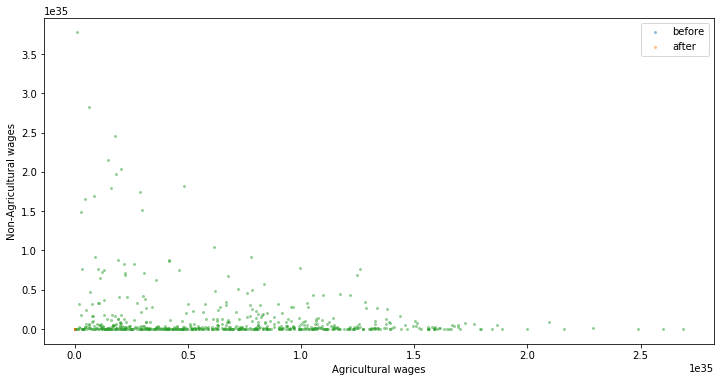

In [109]:
# wages = readWages()

def draw(wages):
    plot_params = {
        'alpha': 0.4,
        's': 4
    }
    
    plt.scatter(wages[t,A], wages[t,NA],
           **plot_params)
    
    
plt.figure(figsize=(12,6))

# before
draw(wages)
draw(wages)

newWages = loopy(wages)

# after
draw(newWages)
plt.legend(['before', 'after'])
plt.xlabel('Agricultural wages'); plt.ylabel('Non-Agricultural wages')

In [51]:

def psi(r):
    n = param.eta
    ret = 1 + (param.beta**(1/(1-n))) * ((1+r)**(n/(1-n)))
    return 1/ret

interest_rate = param.r
consumption_share = psi(interest_rate)

aa = myGamma(param.eta/param.zeta)/param.eta
bb = consumption_share**(param.eta-1)

print(interest_rate, consumption_share, aa,bb)

2.8866 0.7655096595807223 0.7005475951092922 1.1896852061132865


In [75]:
def computeMobility(wages):
    n = param.eta
    _,_,Theta = computeTheta(wages)
    
    # since the interest rate is a constant, we can take psi(r_{t+1}) to be a constant too
    W_rt = aa*bb * (myGamma(param.zeta)*Theta)**n + amenities[1] # amenities in 1910

    # tau is indexed like j x r
    stuff = np.expand_dims(W_rt, 2) - tau

    sums = np.sum(np.exp(1/param.kappa * stuff), axis=3) # across the R's, not the j's
    sums = np.expand_dims(sums, 3)

    movingProbs = np.exp(1/param.kappa * stuff)/sums 
    oldL = np.expand_dims((Lrt*lam_rt), axis=3)
    new = np.sum(movingProbs * oldL, axis=2)
    
    return new

newSkills = computeMobility(wages)
np.sum(newSkills, axis=R) # note that the overall lambda stays the same... since we didn't change that part

array([[0.7046579 , 0.29534209]])

 skill1880: (645, 2)
Iteration #87: 7.888615312408202e-07
L---- #0: 0.3771393027420872
Iteration #36: 7.52566719792686e-07
Iteration #31: 8.439930452520002e-07
Iteration #31: 6.564110557917922e-07
Iteration #30: 8.842706772787538e-07
Iteration #30: 7.343695623091035e-07
Iteration #29: 9.990296768014992e-07
Iteration #29: 8.438278545173821e-07
Iteration #29: 7.19695566209046e-07
Iteration #29: 6.189223498653202e-07
Iteration #28: 8.731162061284692e-07
L---- #10: 0.037872021013707735
Iteration #28: 7.627905980908689e-07
Iteration #28: 6.728810088224781e-07
Iteration #27: 9.740066748748709e-07
Iteration #27: 8.737929532729724e-07
Iteration #27: 7.900454593952586e-07
Iteration #27: 7.192997894358568e-07
Iteration #27: 6.58966018246033e-07
Iteration #26: 9.876929583492818e-07
Iteration #26: 9.151430453710214e-07
Iteration #26: 8.536231928245925e-07
L---- #20: 0.01792319379401997
Iteration #26: 8.013491717688801e-07
Iteration #26: 7.557985367419856e-07
Iteration #26: 7.147918742754146e-07
It

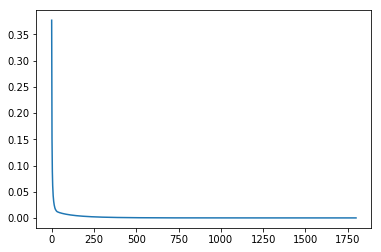

In [53]:
lr = 0.9
losses = []

newWages  = readWages()
skills = readSkills()

for i in range(1800):
    overall_lamda = np.sum(skills, axis=R) # this is \lambda overall
    Lrt = np.sum(skills, axis=S)
    lam_rt = (skills/Lrt)
    
    # find a fixed point wage, given location
    newWages = loopy(newWages, log=False)
    
    # find the new locations, given the wage
    newSkills = computeMobility(newWages)
    
    loss = np.sum(np.abs(newSkills - skills))
    losses.append(loss)
    
    skills = lr * newSkills + (1-lr)*skills
    
    if loss < 1e-6:
        break
    
    if i % 10 == 0:
        print('L---- #{}: {}'.format(i, loss))
        
plt.plot(losses)

In [54]:
skills

array([[[2.48830383e-05, 1.35016432e-05, 5.95746103e-06, ...,
         1.81692794e-03, 4.88644925e-04, 2.25966879e-01],
        [1.01077171e-05, 5.48652739e-06, 2.43413475e-06, ...,
         7.35584403e-04, 2.05933705e-04, 9.20485293e-02]]])

In [59]:
newWages

array([[[4.54369268e-02, 1.95619961e-02, 1.91831742e-02, ...,
         1.42649536e-03, 4.04192632e-03, 2.27085763e-03],
        [3.42860404e-04, 1.79977253e-04, 6.63438375e-05, ...,
         4.59283305e-04, 4.47986406e-03, 9.94990763e-04]]])

In [57]:
# we don't any new wages with this location
nex = loopy(newWages)

Iteration #0: 5.906800931543918e-07


In [64]:
# and we don't get any new locations either
locs = computeMobility(nex)

# the new locations and the one we get are the same
np.sum(np.abs(locs - skills))

1.437998733305172e-07

## Are these the 1910 wages and locations?

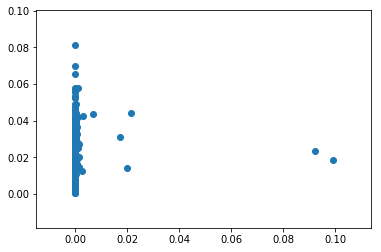

In [76]:
plt.scatter(skills[t,H], wages[t,H])
plt.show()

(array([640.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   2.]),
 array([4.50385446e-08, 9.89161957e-03, 1.97831941e-02, 2.96747686e-02,
        3.95663432e-02, 4.94579177e-02, 5.93494922e-02, 6.92410667e-02,
        7.91326413e-02, 8.90242158e-02, 9.89157903e-02]),
 <a list of 10 Patch objects>)

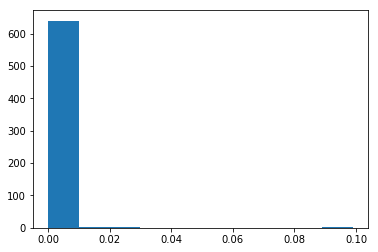

In [78]:
plt.hist(skills[t,H])